In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
pred_steps = 100

In [ ]:
latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [ ]:
df = pd.read_csv("drive/MyDrive/all_infants_hr.csv")

In [ ]:
df

,n_infant,Unnamed: 1,Unnamed: 0,n_infant.1,brady,hr,rri
0,1,134,134,1,0.0,157.894737,0.380
1,1,228,228,1,0.0,159.574468,0.376
2,1,323,323,1,0.0,157.894737,0.380
3,1,418,418,1,0.0,157.894737,0.380
4,1,512,512,1,0.0,159.574468,0.376
...,...,...,...,...,...,...,...
3797488,10,81249108,81249108,10,0.0,180.722892,0.332
3797489,10,81249274,81249274,10,0.0,180.722892,0.332
3797490,10,81249440,81249440,10,0.0,180.722892,0.332
3797491,10,81249607,81249607,10,0.0,179.640719,0.334


In [ ]:
df1 = df[0:10000].copy()
len(df1)
df1.isnull().any()

n_infant      False
Unnamed: 1    False
Unnamed: 0    False
n_infant.1    False
brady         False
hr            False
rri           False
dtype: bool

In [ ]:
def stridedApp(a, elength, dlength, stride):
    #cols = [str(i) for i in range()]
    row = []
    a = a.reset_index(drop = True)
    for i in range(0, len(a), stride):
        if(i+elength+dlength>len(a)):
          break

        x = list(a['hr'][i:i+elength])
        y = list(a['hr'][i+elength: i+elength+dlength])
        input_sequence = list(a['hr'][i+elength+1 : i+elength+dlength])
        encoding_ts = a['Unnamed: 0'][i]
        decoding_ts = a['Unnamed: 0'][i+elength]
        infant_number = a['n_infant'][i]
        
        windowed_df = pd.DataFrame([x + y + input_sequence])
        windowed_df.insert(0, 'Infant Number', infant_number)
        windowed_df.insert(1, 'Encoding TS', encoding_ts)
        windowed_df.insert(2, 'Decoding TS', decoding_ts)
        # windowed_df.insert(3, 'X', x)
        # windowed_df.insert(4, 'y',y)
        row.append(windowed_df)
        del windowed_df
    row = pd.concat(row)
    return row

In [ ]:
dataframe = stridedApp(df, 300, 100, 150)

In [ ]:
dataframe

,Infant Number,Encoding TS,Decoding TS,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498
0,1,134,28419,157.894737,159.574468,157.894737,157.894737,159.574468,154.639175,157.894737,151.515152,154.639175,153.061224,156.250000,156.250000,154.639175,154.639175,156.250000,156.250000,157.894737,156.250000,157.894737,157.894737,157.894737,159.574468,159.574468,159.574468,161.290323,159.574468,161.290323,161.290323,161.290323,161.290323,163.043478,161.290323,159.574468,163.043478,161.290323,161.290323,163.043478,...,161.290323,157.894737,159.574468,157.894737,161.290323,159.574468,159.574468,159.574468,159.574468,161.290323,161.290323,161.290323,161.290323,163.043478,161.290323,161.290323,163.043478,161.290323,161.290323,163.043478,161.290323,159.574468,159.574468,161.290323,159.574468,159.574468,157.894737,161.290323,159.574468,159.574468,157.894737,159.574468,159.574468,161.290323,159.574468,159.574468,159.574468,161.290323,159.574468,161.290323
0,1,14040,42587,159.574468,161.290323,161.290323,161.290323,163.043478,161.290323,163.043478,161.290323,163.043478,163.043478,163.043478,161.290323,161.290323,164.835165,161.290323,161.290323,161.290323,163.043478,161.290323,161.290323,159.574468,161.290323,159.574468,161.290323,157.894737,157.894737,156.250000,157.894737,157.894737,151.515152,157.894737,151.515152,148.514851,153.061224,153.061224,156.250000,156.250000,...,164.835165,164.835165,163.043478,164.835165,164.835165,164.835165,161.290323,164.835165,163.043478,163.043478,161.290323,163.043478,163.043478,163.043478,163.043478,161.290323,163.043478,163.043478,163.043478,161.290323,163.043478,164.835165,163.043478,164.835165,164.835165,164.835165,164.835165,164.835165,164.835165,166.666667,164.835165,166.666667,166.666667,166.666667,164.835165,166.666667,166.666667,166.666667,164.835165,166.666667
0,1,28419,56541,156.250000,156.250000,154.639175,153.061224,156.250000,154.639175,154.639175,154.639175,156.250000,156.250000,154.639175,156.250000,156.250000,156.250000,156.250000,153.061224,154.639175,153.061224,154.639175,154.639175,153.061224,154.639175,153.061224,150.000000,151.515152,150.000000,151.515152,150.000000,151.515152,151.515152,151.515152,153.061224,151.515152,151.515152,151.515152,151.515152,153.061224,...,151.515152,151.515152,147.058824,148.514851,147.058824,142.857143,142.857143,144.230769,140.186916,138.888889,142.857143,145.631068,148.514851,144.230769,144.230769,147.058824,147.058824,147.058824,144.230769,148.514851,145.631068,150.000000,148.514851,151.515152,147.058824,148.514851,151.515152,150.000000,148.514851,151.515152,150.000000,148.514851,150.000000,150.000000,150.000000,151.515152,147.058824,148.514851,147.058824,148.514851
0,1,42587,71726,163.043478,163.043478,164.835165,163.043478,163.043478,163.043478,161.290323,161.290323,159.574468,157.894737,157.894737,157.894737,154.639175,156.250000,157.894737,157.894737,159.574468,159.574468,157.894737,159.574468,157.894737,159.574468,161.290323,159.574468,161.290323,161.290323,163.043478,163.043478,163.043478,163.043478,163.043478,163.043478,164.835165,163.043478,163.043478,163.043478,164.835165,...,126.050420,112.781955,112.781955,120.967742,135.135135,137.614679,141.509434,147.058824,144.230769,137.614679,140.186916,144.230769,133.928571,141.509434,142.857143,132.743363,137.614679,141.509434,126.050420,133.928571,138.888889,131.578947,129.310345,136.363636,138.888889,142.857143,144.230769,147.058824,147.058824,150.000000,150.000000,151.515152,151.515152,153.061224,153.061224,154.639175,153.061224,153.061224,154.639175,154.639175
0,1,56541,87340,144.230769,145.631068,147.058824,150.000000,150.000000,151.515152,148.514851,151.515152,154.639175,154.639175,154.639175,156.250000,154.639175,154.639175,154.639175,154.639175,151.515152,150.000000,150.000000,142.8

In [ ]:
dataframe.insert(403, '403', 0)

In [ ]:
encoder_input_data = dataframe[dataframe.columns[3:303]]
decoder_target_data = dataframe[dataframe.columns[303:403]]
decoder_input_data = dataframe[dataframe.columns[403:]]
encoder_input_data = np.expand_dims(encoder_input_data, axis = 2)
decoder_input_data = np.expand_dims(decoder_input_data, axis = 2)
decoder_target_data = np.expand_dims(decoder_target_data, axis = 2)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
x_train_encoder_input_data = dataframe[dataframe.columns[3:303]][0:22000]
x_test_encoder_input_data = dataframe[dataframe.columns[3:303]][22000:]
x_train_decoder_input_data = dataframe[dataframe.columns[403:]][0:22000]
x_test_decoder_input_data = dataframe[dataframe.columns[403:]][22000:]
x_train_decoder_target_data = dataframe[dataframe.columns[303:403]][0:22000]
x_test_decoder_target_data = dataframe[dataframe.columns[303:403]][22000:]

In [ ]:
x_train_encoder_input_data = dataframe[dataframe.columns[3:303]][0:22000]
x_train_encoder_input_data.shape

(22000, 300)

In [ ]:
# decoder_input_data = np.zeros(decoder_target_data.shape)
# decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
# # decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]
# decoder_input_data.shape

In [ ]:
batch_size = 64
epochs = 15
model.compile(Adam(), loss='mean_squared_error')
model.summary()
history = model.fit([x_train_encoder_input_data, x_train_decoder_input_data ], x_train_decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50), (None,  10400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm[0][1]            

In [ ]:

# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).
   
    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [ ]:
# encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
# encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
# decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [ ]:
import matplotlib.pyplot as plt
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

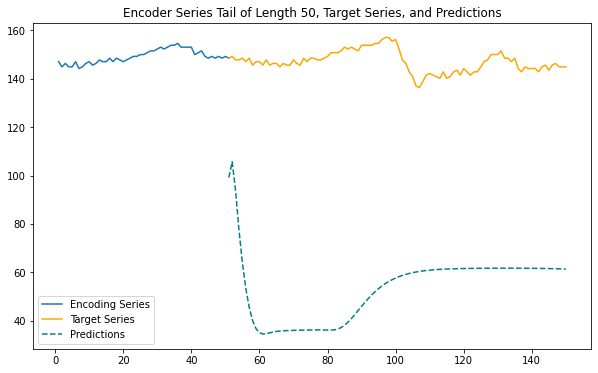

In [ ]:
predict_and_plot(encoder_input_data, decoder_target_data, 23000)

In [ ]:
x_train_encoder_input_data.shape

(22000, 300)

In [ ]:
encoder_input_data.shape

(25314, 300, 1)